In [20]:
# I think its time to go back to creating the final Airtable tool.
# In hindsight, and given that ToolNode can execute tools in parallel, I've given up the idea of using the batch_upsert method.
# This will be better for simplicity and modularity.

In [21]:
# First: the read tool

from typing import List
from langchain_core.tools import tool
from langchain.pydantic_v1 import Field, BaseModel
from pyairtable import Api
import os

@tool # Should be as simple as this
def read_tool(
    only_active: bool = Field(default=True, description="Whether to only return active tasks or all tasks.")
) -> List[dict]:
    """
    Gets all tasks currently attributed to the user.
    By default, only active tasks are returned.
    Setting only_active to False will return all tasks, including completed ones.
    """
    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')
    if only_active:
        return table.all(view='Pending')
    return table.all()


In [22]:
# Let's test it
read_tool.invoke(dict())

[{'id': 'rectOlffsIq1iLK3M',
  'createdTime': '2024-07-02T19:17:18.000Z',
  'fields': {'unique_id': 109,
   'Task': 'Levar o gato no veterinario',
   'Status': 'A iniciar'}},
 {'id': 'recgff5Ffk8thiJ3t',
  'createdTime': '2024-07-02T19:17:32.000Z',
  'fields': {'unique_id': 110, 'Task': 'Viajar', 'Status': 'Em andamento'}},
 {'id': 'recAt5y0gvPP8qmNL',
  'createdTime': '2024-07-02T19:25:41.000Z',
  'fields': {'unique_id': 112,
   'Task': 'Estudar para a prova de matemática',
   'Description': 'Revisar todos os capítulos, resolver exercícios e revisar notas da aula',
   'Status': 'A iniciar'}}]

In [40]:
# Second: the create tool

# Now we start needing a pydantic model for the input
from enum import Enum
from typing import Optional

class StatusEnum(str, Enum):
    A_INICIAR = 'A iniciar'
    EM_ANDAMENTO = 'Em andamento'
    CONCLUIDA = 'Concluída'
    CANCELADA = 'Cancelada'
    MESCLADA = 'Mesclada'

class CreateTaskFields(BaseModel):
    Task: str = Field(description="A short description of the task.", min_length=1)
    Description: Optional[str] = Field(description="A more detailed description of the task.")
    Status: StatusEnum = Field(description="The status of the task. 'Mesclada' means the task was merged with another one.")

@tool
def create_tool(records: List[CreateTaskFields]) -> List[dict]:
    """
    Should always be preceded by a read_tool call, so one can know the current state of the tasks.
    Creates one or more tasks in the user's task list.
    Tasks should only contain necessary information, and no information should be added or infered.
    """
    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')

    # We need to convert the records to a format that Airtable can understand
    records = [record.dict() for record in records]
    return table.batch_create(records=records)


In [24]:
# Starting to need a graph here.

In [25]:
from typing import Annotated # This is what will allow us to pass the reductor function to our State class

from typing_extensions import TypedDict # So we can better 'lock' the datatypes for our state attributes

from langgraph.graph import StateGraph # The main structure of our graph
from langgraph.graph.message import add_messages # This is a prebuilt function that does the reductor job. Could be manually implemented.

In [26]:
class State(TypedDict):
    """
    The State class is a TypedDict that will hold the attributes of our state.
    The add_messages reductor function will guarantee that when a node simply returns the new message, it is appended instead of replacing the previous ones.
    """
    messages: Annotated[list, add_messages]

In [27]:
graph_builder = StateGraph(State)

In [28]:
# The model...
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [29]:
# Binding

llm_with_tools = llm.bind_tools([read_tool, create_tool])

In [30]:
# The LLM node itself
def chatbot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node('chatbot', chatbot)

graph_builder.set_entry_point('chatbot')

In [31]:
# The tool node now

from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[read_tool, create_tool])

graph_builder.add_node('tool_node', tool_node)

In [32]:
from typing import Literal

def route_tools(state: State,) -> Literal["tools","__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    The values returned here are arbitrary, but it makes sense to name them after the node in the graph they should route to.
    """

    # First we must get the last message from the state.
    # We are looking necessarily for an AIMessage, since those are the ones that call tools.
    # The introduction notebook adds a few validation if-elses, some of which are unnecessary.

    # A try-except solves my current needs
    try:
        last_message = state["messages"][-1]
    except: 
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Now we check if the last message has tool calls.
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools" # Logic being: 'Look, there's a tool call. So we should route to the 'tools' node.
    return "__end__"

In [33]:
graph_builder.add_conditional_edges('chatbot', route_tools, {'tools':'tool_node', '__end__':'__end__'})

In [34]:
graph_builder.add_edge('tool_node', 'chatbot')

In [35]:
graph = graph_builder.compile()

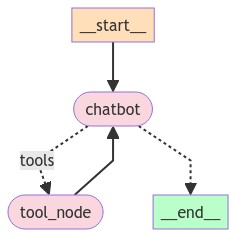

In [36]:
# Once again visualizing the graph

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
from langchain_core.messages import HumanMessage, BaseMessage

In [38]:
# Testing no tool usage.
user_input = HumanMessage("Eu preciso estudar pra prova de matemática.")

for event in graph.stream({"messages": user_input}, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Eu preciso estudar pra prova de matemática.
================================== Ai Message ==================================
Tool Calls:
  read_tool (call_n2UwMrISklOrtFfJ5cwCChZv)
 Call ID: call_n2UwMrISklOrtFfJ5cwCChZv
  Args:
================================= Tool Message =================================
Name: read_tool

[{"id": "rectOlffsIq1iLK3M", "createdTime": "2024-07-02T19:17:18.000Z", "fields": {"unique_id": 109, "Task": "Levar o gato no veterinario", "Status": "A iniciar"}}, {"id": "recgff5Ffk8thiJ3t", "createdTime": "2024-07-02T19:17:32.000Z", "fields": {"unique_id": 110, "Task": "Viajar", "Status": "Em andamento"}}, {"id": "recAt5y0gvPP8qmNL", "createdTime": "2024-07-02T19:25:41.000Z", "fields": {"unique_id": 112, "Task": "Estudar para a prova de matem\u00e1tica", "Description": "Revisar todos os cap\u00edtulos, resolver exerc\u00edcios e revisar notas da aula", "Status": "A iniciar"}}]
====

In [50]:
# Third: the update tool


class UpdateTaskFields(TypedDict):
    Description: Optional[str] = Field(description="An updated description of the task, if needed.")
    Status: StatusEnum = Field(description="The status of the task. 'Mesclada' means the task was merged with another one.")

class UpdateTaskRecord(UpdateTaskFields):
    id: str = Field(description="The unique id for the record that'll be updated. Must be preexisting.", pattern='rec[A-Za-z0-9]{14}')
    fields: UpdateTaskFields = Field(description="The fields to be updated with their new values.")
    

@tool
def update_tool(records: List[UpdateTaskRecord]) -> List[dict]:
    """
    Should always be preceded by a read_tool call, so one can know the current state of the tasks.
    Alters one or more existing tasks in the user's task list.
    Tasks should only contain necessary information, and no information should be added or infered.
    """
    api = Api(os.environ['AIRTABLE_ACCESS_TOKEN'])
    table = api.table(os.environ['AIRTABLE_BASE_ID'], 'Tasks')

    # We need to convert the records to a format that Airtable can understand
    #records = [record.dict() for record in records]
    return table.batch_update(records=records)


In [51]:
# Recreating the graph

graph_builder = StateGraph(State)
llm = ChatOpenAI(model='gpt-4o').bind_tools([read_tool, create_tool, update_tool])

def chatbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}

graph_builder.add_node('chatbot', chatbot)

graph_builder.set_entry_point('chatbot')

tool_node = ToolNode(tools=[read_tool, create_tool, update_tool])

graph_builder.add_node('tool_node', tool_node)

graph_builder.add_conditional_edges('chatbot', route_tools, {'tools':'tool_node', '__end__':'__end__'})

graph_builder.add_edge('tool_node', 'chatbot')

graph = graph_builder.compile()

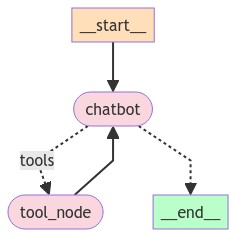

In [52]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [44]:
# Let's see
user_input = HumanMessage("Quanto é 2+2?")

for event in graph.stream({"messages": user_input}, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Quanto é 2+2?
================================== Ai Message ==================================

2 + 2 é igual a 4.


In [45]:
# Let's see
user_input = HumanMessage("Eu tenho que estudar pra algo?")

for event in graph.stream({"messages": user_input}, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Eu tenho que estudar pra algo?
================================== Ai Message ==================================
Tool Calls:
  read_tool (call_Ic7ITtOTl8NVsxQTAZk9IhDV)
 Call ID: call_Ic7ITtOTl8NVsxQTAZk9IhDV
  Args:
    only_active: True
================================= Tool Message =================================
Name: read_tool

[{"id": "rectOlffsIq1iLK3M", "createdTime": "2024-07-02T19:17:18.000Z", "fields": {"unique_id": 109, "Task": "Levar o gato no veterinario", "Status": "A iniciar"}}, {"id": "recgff5Ffk8thiJ3t", "createdTime": "2024-07-02T19:17:32.000Z", "fields": {"unique_id": 110, "Task": "Viajar", "Status": "Em andamento"}}, {"id": "recAt5y0gvPP8qmNL", "createdTime": "2024-07-02T19:25:41.000Z", "fields": {"unique_id": 112, "Task": "Estudar para a prova de matem\u00e1tica", "Description": "Revisar todos os cap\u00edtulos, resolver exerc\u00edcios e revisar notas da aula", "Status": "A iniciar

In [54]:
# Let's see
user_input = HumanMessage("Terminei de estudar.")

for event in graph.stream({"messages": user_input}, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Terminei de estudar.
================================== Ai Message ==================================
Tool Calls:
  read_tool (call_acRCKkN1DAEpimWlWC1bu5mj)
 Call ID: call_acRCKkN1DAEpimWlWC1bu5mj
  Args:
    only_active: True
================================= Tool Message =================================
Name: read_tool

[{"id": "rectOlffsIq1iLK3M", "createdTime": "2024-07-02T19:17:18.000Z", "fields": {"unique_id": 109, "Task": "Levar o gato no veterinario", "Status": "A iniciar"}}, {"id": "recgff5Ffk8thiJ3t", "createdTime": "2024-07-02T19:17:32.000Z", "fields": {"unique_id": 110, "Task": "Viajar", "Status": "Em andamento"}}]
================================== Ai Message ==================================
Tool Calls:
  update_tool (call_Iweoov1LMolFQg5BE1M7BSLA)
 Call ID: call_Iweoov1LMolFQg5BE1M7BSLA
  Args:
    records: [{'Description': 'Estudar', 'Status': 'Concluída', 'id': 'rectOlffsIq1iLK3M', 'fi